In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import torch
import nrrd
import torchvision.transforms as transforms
from tqdm import tqdm
%matplotlib inline


In [2]:
INPUT_SHAPE = (192, 192, 3)
epochs = 10
batch_size = 32
valratio = 0.15

In [3]:
train_path = 'HACKATHON/images/train/'
test_path = 'HACKATHON/images/test/'
label_path = 'HACKATHON/train.txt'

In [4]:
ss = []
with open(label_path, 'r') as f:
    for row in f:
        ss.append(row)

In [5]:
len(os.listdir(train_path))

355

In [6]:
def loadnib(path, root = train_path):
    scan = nib.load(train_path+ path)
    return np.array(scan.dataobj)

In [7]:
img = loadnib('0657.nii.gz')
img.shape, img[0].shape

((512, 512, 66), (512, 66))

In [8]:
def nibtoimg(path, root = train_path, slc = 25, file = 't.jpg'):
    scan = nib.load(train_path+ path)
    scan = np.array(scan.dataobj)
    t = np.rot90(scan[:,:,slc], k=3)
    plt.imsave(file, t)

In [9]:
nibtoimg('0032.nii.gz')

In [10]:
def plot_slice(img, slc):
    plt.imshow(np.rot90(img[:,:,slc], k=3),cmap='gray')

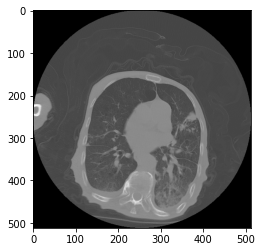

In [11]:
plot_slice(img, 34)

In [12]:
labels = []
for k in sorted(ss):
    a,b = k.split(',')
    labels.append(int(b))

In [13]:
labels = np.array(labels)
labels.shape

(355,)

In [14]:
def save_img(img, path = 'output.jpeg'):
    plt.imsave(path, img, cmap = 'gray')

In [264]:
from PIL import Image
def rgb_loader(path):
    img = Image.open(path)
    return img.convert('RGB')


def transform(x):
    operation = transforms.Compose([
                transforms.Resize((352, 352)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                    [0.229, 0.224, 0.225])
    ])
    return operation(x).unsqueeze(0)

In [203]:
def get_ready(n, slc = 0):
    n = n.astype('float32')
    im = Image.fromarray(n[:,:,slc])
    im = im.convert('RGB')
    return transform(im)

In [204]:
def gen(path = train_path):
    for filepath in os.listdir(path):
        try:
            scan = nib.load(path+filepath)
            yield np.array(scan.dataobj)
        except StopIteration:
            break;

In [205]:
g = gen()

In [206]:
n = next(g)
n = n.astype('float32')


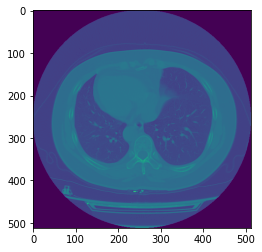

In [207]:
plt.imshow(np.rot90(n[:,:,23], k = 3))

In [208]:
print("You mothafucka")

You mothafucka


## Semi Inf-Net

In [219]:
!mkdir -p Results/semi

In [220]:
save_path = 'Results/semi'

In [221]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
import torch
import torch.nn.functional as F

__all__ = ['Res2Net', 'res2net50_v1b', 'res2net101_v1b', 'res2net50_v1b_26w_4s']

model_urls = {
    'res2net50_v1b_26w_4s': 'https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net50_v1b_26w_4s-3cf99910.pth',
    'res2net101_v1b_26w_4s': 'https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net101_v1b_26w_4s-0812c246.pth',
}


class Bottle2neck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, baseWidth=26, scale=4, stype='normal'):
        """ Constructor
        Args:
            inplanes: input channel dimensionality
            planes: output channel dimensionality
            stride: conv stride. Replaces pooling layer.
            downsample: None when stride = 1
            baseWidth: basic width of conv3x3
            scale: number of scale.
            type: 'normal': normal set. 'stage': first block of a new stage.
        """
        super(Bottle2neck, self).__init__()

        width = int(math.floor(planes * (baseWidth / 64.0)))
        self.conv1 = nn.Conv2d(inplanes, width * scale, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width * scale)

        if scale == 1:
            self.nums = 1
        else:
            self.nums = scale - 1
        if stype == 'stage':
            self.pool = nn.AvgPool2d(kernel_size=3, stride=stride, padding=1)
        convs = []
        bns = []
        for i in range(self.nums):
            convs.append(nn.Conv2d(width, width, kernel_size=3, stride=stride, padding=1, bias=False))
            bns.append(nn.BatchNorm2d(width))
        self.convs = nn.ModuleList(convs)
        self.bns = nn.ModuleList(bns)

        self.conv3 = nn.Conv2d(width * scale, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stype = stype
        self.scale = scale
        self.width = width

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        spx = torch.split(out, self.width, 1)
        for i in range(self.nums):
            if i == 0 or self.stype == 'stage':
                sp = spx[i]
            else:
                sp = sp + spx[i]
            sp = self.convs[i](sp)
            sp = self.relu(self.bns[i](sp))
            if i == 0:
                out = sp
            else:
                out = torch.cat((out, sp), 1)
        if self.scale != 1 and self.stype == 'normal':
            out = torch.cat((out, spx[self.nums]), 1)
        elif self.scale != 1 and self.stype == 'stage':
            out = torch.cat((out, self.pool(spx[self.nums])), 1)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Res2Net(nn.Module):

    def __init__(self, block, layers, baseWidth=26, scale=4, num_classes=1000):
        self.inplanes = 64
        super(Res2Net, self).__init__()
        self.baseWidth = baseWidth
        self.scale = scale
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 1, 1, bias=False)
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.AvgPool2d(kernel_size=stride, stride=stride,
                             ceil_mode=True, count_include_pad=False),
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample=downsample,
                            stype='stage', baseWidth=self.baseWidth, scale=self.scale))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, baseWidth=self.baseWidth, scale=self.scale))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def res2net50_v1b(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b model_lung_infection.
    Res2Net-50 refers to the Res2Net-50_v1b_26w_4s.
    Args:
        pretrained (bool): If True, returns a model_lung_infection pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 6, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net50_v1b_26w_4s']),map_location=torch.device('cpu') )
    return model


def res2net101_v1b(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s model_lung_infection.
    Args:
        pretrained (bool): If True, returns a model_lung_infection pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 23, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net101_v1b_26w_4s']))
    return model


def res2net50_v1b_26w_4s(pretrained=True, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s model_lung_infection.
    Args:
        pretrained (bool): If True, returns a model_lung_infection pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 6, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        # Please replace it with your custom path
        model_state = torch.load('res2net50_v1b_26w_4s-3cf99910.pth', map_location=torch.device('cpu'))
        model.load_state_dict(model_state)
        # model_lung_infection.load_state_dict(model_zoo.load_url(model_urls['res2net50_v1b_26w_4s']))
    return model


def res2net101_v1b_26w_4s(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s model_lung_infection.
    Args:
        pretrained (bool): If True, returns a model_lung_infection pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 23, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net101_v1b_26w_4s']))
    return model


def res2net152_v1b_26w_4s(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s model_lung_infection.
    Args:
        pretrained (bool): If True, returns a model_lung_infection pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 8, 36, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net152_v1b_26w_4s']))
    return model

In [338]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x


class RFB_modified(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(RFB_modified, self).__init__()
        self.relu = nn.ReLU(True)
        self.branch0 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
        )
        self.branch1 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 3), padding=(0, 1)),
            BasicConv2d(out_channel, out_channel, kernel_size=(3, 1), padding=(1, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=3, dilation=3)
        )
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 5), padding=(0, 2)),
            BasicConv2d(out_channel, out_channel, kernel_size=(5, 1), padding=(2, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=5, dilation=5)
        )
        self.branch3 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 7), padding=(0, 3)),
            BasicConv2d(out_channel, out_channel, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=7, dilation=7)
        )
        self.conv_cat = BasicConv2d(4*out_channel, out_channel, 3, padding=1)
        self.conv_res = BasicConv2d(in_channel, out_channel, 1)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = self.conv_cat(torch.cat((x0, x1, x2, x3), 1))

        x = self.relu(x_cat + self.conv_res(x))
        return x


class aggregation(nn.Module):
    # dense aggregation, it can be replaced by other aggregation previous, such as DSS, amulet, and so on.
    # used after MSF
    def __init__(self, channel, n_class):
        super(aggregation, self).__init__()
        self.relu = nn.ReLU(True)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_upsample1 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample2 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample3 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample4 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample5 = BasicConv2d(2*channel, 2*channel, 3, padding=1)

        self.conv_concat2 = BasicConv2d(2*channel, 2*channel, 3, padding=1)
        self.conv_concat3 = BasicConv2d(3*channel, 3*channel, 3, padding=1)
        self.conv4 = BasicConv2d(3*channel, 3*channel, 3, padding=1)
        self.conv5 = nn.Conv2d(3*channel, n_class, 1)

    def forward(self, x1, x2, x3):
        x1_1 = x1
        x2_1 = self.conv_upsample1(self.upsample(x1)) * x2
        x3_1 = self.conv_upsample2(self.upsample(self.upsample(x1))) \
               * self.conv_upsample3(self.upsample(x2)) * x3

        x2_2 = torch.cat((x2_1, self.conv_upsample4(self.upsample(x1_1))), 1)
        x2_2 = self.conv_concat2(x2_2)

        x3_2 = torch.cat((x3_1, self.conv_upsample5(self.upsample(x2_2))), 1)
        x3_2 = self.conv_concat3(x3_2)

        x = self.conv4(x3_2)
        x = self.conv5(x)

        return x


class Inf_Net(nn.Module):
    def __init__(self, channel=32, n_class=1):
        super(Inf_Net, self).__init__()
        # ---- ResNet Backbone ----
        self.resnet = res2net50_v1b_26w_4s(pretrained=True)
        # ---- Receptive Field Block like module ----
        self.rfb2_1 = RFB_modified(512, channel)
        self.rfb3_1 = RFB_modified(1024, channel)
        self.rfb4_1 = RFB_modified(2048, channel)

        # ---- Partial Decoder ----
        self.ParDec = aggregation(channel, n_class)

        # ---- reverse attention branch 4 ----
        self.ra4_conv1 = BasicConv2d(2048, 256, kernel_size=1)
        self.ra4_conv2 = BasicConv2d(256+64, 256, kernel_size=5, padding=2)
        self.ra4_conv3 = BasicConv2d(256, 256, kernel_size=5, padding=2)
        self.ra4_conv4 = BasicConv2d(256, 256, kernel_size=5, padding=2)
        self.ra4_conv5 = BasicConv2d(256, n_class, kernel_size=1)
        # ---- reverse attention branch 3 ----
        self.ra3_conv1 = BasicConv2d(1024, 64, kernel_size=1)
        self.ra3_conv2 = BasicConv2d(64+64, 64, kernel_size=3, padding=1)
        self.ra3_conv3 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.ra3_conv4 = BasicConv2d(64, n_class, kernel_size=3, padding=1)
        # ---- reverse attention branch 2 ----
        self.ra2_conv1 = BasicConv2d(512, 64, kernel_size=1)
        self.ra2_conv2 = BasicConv2d(64+64, 64, kernel_size=3, padding=1)
        self.ra2_conv3 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.ra2_conv4 = BasicConv2d(64, n_class, kernel_size=3, padding=1)

        # ---- edge branch ----
        self.edge_conv1 = BasicConv2d(256, 64, kernel_size=1)
        self.edge_conv2 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.edge_conv3 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.edge_conv4 = BasicConv2d(64, n_class, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)

        # ---- low-level features ----
        x = self.resnet.maxpool(x)      # bs, 64, 88, 88
        x1 = self.resnet.layer1(x)      # bs, 256, 88, 88

        # ---- high-level features ----
        x2 = self.resnet.layer2(x1)     # bs, 512, 44, 44
        x3 = self.resnet.layer3(x2)     # bs, 1024, 22, 22
        x4 = self.resnet.layer4(x3)     # bs, 2048, 11, 11
        x2_rfb = self.rfb2_1(x2)        # channel -> 32
        x3_rfb = self.rfb3_1(x3)        # channel -> 32
        x4_rfb = self.rfb4_1(x4)        # channel -> 32

        # ---- edge guidance ----
        x = self.edge_conv1(x1)
        x = self.edge_conv2(x)
        edge_guidance = self.edge_conv3(x)  # torch.Size([1, 64, 88, 88])
        lateral_edge = self.edge_conv4(edge_guidance)   # NOTES: Sup-2 (bs, 1, 88, 88) -> (bs, 1, 352, 352)
        lateral_edge = F.interpolate(lateral_edge,
                                     scale_factor=4,
                                     mode='bilinear')

        # ---- global guidance ----
        ra5_feat = self.ParDec(x4_rfb, x3_rfb, x2_rfb)
        lateral_map_5 = F.interpolate(ra5_feat,
                                      scale_factor=8,
                                      mode='bilinear')    # NOTES: Sup-1 (bs, 1, 44, 44) -> (bs, 1, 352, 352)

        # ---- reverse attention branch_4 ----
        crop_4 = F.interpolate(ra5_feat, scale_factor=0.25, mode='bilinear')
        x = -1*(torch.sigmoid(crop_4)) + 1  # reverse
        x = x.expand(-1, 2048, -1, -1).mul(x4)
        x = torch.cat((self.ra4_conv1(x), F.interpolate(edge_guidance, scale_factor=1/8, mode='bilinear')), dim=1)
        x = F.relu(self.ra4_conv2(x))
        x = F.relu(self.ra4_conv3(x))
        x = F.relu(self.ra4_conv4(x))
        ra4_feat = self.ra4_conv5(x)
        x = ra4_feat + crop_4   # element-wise addition
        lateral_map_4 = F.interpolate(x,
                                      scale_factor=32,
                                      mode='bilinear')  # NOTES: Sup-2 (bs, 1, 11, 11) -> (bs, 1, 352, 352)

        # ---- reverse attention branch_3 ----
        crop_3 = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = -1*(torch.sigmoid(crop_3)) + 1
        x = x.expand(-1, 1024, -1, -1).mul(x3)
        x = torch.cat((self.ra3_conv1(x), F.interpolate(edge_guidance, scale_factor=1/4, mode='bilinear')), dim=1)
        x = F.relu(self.ra3_conv2(x))
        x = F.relu(self.ra3_conv3(x))
        ra3_feat = self.ra3_conv4(x)
        x = ra3_feat + crop_3
        lateral_map_3 = F.interpolate(x,
                                      scale_factor=16,
                                      mode='bilinear')  # NOTES: Sup-3 (bs, 1, 22, 22) -> (bs, 1, 352, 352)

        # ---- reverse attention branch_2 ----
        crop_2 = F.interpolate(x, scale_factor=2, mode='bilinear')

        x = -1*(torch.sigmoid(crop_2)) + 1
        x = x.expand(-1, 512, -1, -1).mul(x2)
        x = torch.cat((self.ra2_conv1(x), F.interpolate(edge_guidance, scale_factor=1/2, mode='bilinear')), dim=1)
        x = F.relu(self.ra2_conv2(x))
        x = F.relu(self.ra2_conv3(x))
        ra2_feat = self.ra2_conv4(x)
        x = ra2_feat + crop_2
        lateral_map_2 = F.interpolate(x,
                                      scale_factor=8,
                                      mode='bilinear')   # NOTES: Sup-4 (bs, 1, 44, 44) -> (bs, 1, 352, 352)

        return lateral_map_5, lateral_map_4, lateral_map_3, lateral_map_2, lateral_edge


In [339]:
seminet_pth ='Semi-Inf-Net/Semi-Inf-Net-100.pth'
save_test = 'Results/Lung-infection-segmentation/Semi-Inf-Net/'
save_train = 'Results/Lung-infection-segmentation/train/'

In [340]:
semi = Inf_Net()
device = torch.device('cpu')
semi.load_state_dict(torch.load(seminet_pth, map_location=device))

<All keys matched successfully>

In [341]:
#semi.eval()

In [342]:
def predict_semi(k):
    lateral_map_5, lateral_map_4, lateral_map_3, lateral_map_2, lateral_edge = semi(k)
    res = lateral_map_2
    res = res.sigmoid().data.cpu().numpy().squeeze()
    res = (res - res.min()) / (res.max() - res.min() + 1e-8)
    #plt.imsave(save_path + '0.jpeg' ,res, cmap = 'gray')
    #plt.imshow(res, cmap='gray')
    return res

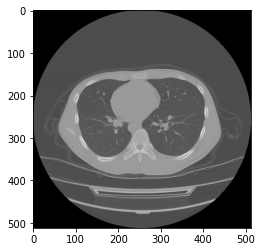

In [343]:
n = next(g)
plot_slice(n, slc = 34)

In [344]:
n = get_ready(n, slc = 34)
x = predict(n)

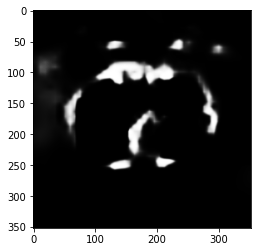

In [345]:
plt.imshow(np.rot90(x), cmap = 'gray')

In [311]:
plt.imsave('semi.jpg', x)

In [312]:
y = transform(rgb_loader('semi.jpg'))
y.shape

torch.Size([1, 3, 352, 352])

In [434]:
semi.eval()
infnet.eval()

Inf_Net_UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05

In [441]:
x = process(filename_img)

 10%|▉         | 6/61 [00:02<00:21,  2.60it/s]

[1 2]


 11%|█▏        | 7/61 [00:04<00:41,  1.31it/s]

[0 1 2]


 13%|█▎        | 8/61 [00:07<01:02,  1.19s/it]

[1 2]


 15%|█▍        | 9/61 [00:09<01:08,  1.32s/it]

[1 2]


 16%|█▋        | 10/61 [00:10<01:11,  1.41s/it]

[1 2]


 18%|█▊        | 11/61 [00:12<01:14,  1.50s/it]

[1 2]


 20%|█▉        | 12/61 [00:14<01:14,  1.52s/it]

[0 1 2]


 21%|██▏       | 13/61 [00:15<01:13,  1.54s/it]

[0 2]


 23%|██▎       | 14/61 [00:17<01:15,  1.61s/it]

[0 1 2]


 25%|██▍       | 15/61 [00:19<01:14,  1.63s/it]

[0 1 2]


 26%|██▌       | 16/61 [00:20<01:13,  1.64s/it]

[0 1 2]


 28%|██▊       | 17/61 [00:22<01:12,  1.64s/it]

[0 2]


 30%|██▉       | 18/61 [00:24<01:11,  1.66s/it]

[0 1 2]


 31%|███       | 19/61 [00:25<01:10,  1.67s/it]

[0 1 2]


 33%|███▎      | 20/61 [00:27<01:12,  1.76s/it]

[0 1 2]


 34%|███▍      | 21/61 [00:29<01:11,  1.80s/it]

[0 1 2]


 36%|███▌      | 22/61 [00:31<01:09,  1.78s/it]

[0 2]


 38%|███▊      | 23/61 [00:33<01:07,  1.79s/it]

[0 1 2]


 39%|███▉      | 24/61 [00:35<01:06,  1.80s/it]

[0 1 2]


 41%|████      | 25/61 [00:37<01:08,  1.91s/it]

[0 1 2]


 43%|████▎     | 26/61 [00:41<01:26,  2.46s/it]

[0 1 2]


 44%|████▍     | 27/61 [00:44<01:36,  2.83s/it]

[1 2]


 46%|████▌     | 28/61 [00:46<01:24,  2.57s/it]

[0 1 2]


 48%|████▊     | 29/61 [00:48<01:19,  2.48s/it]

[0 1 2]


 49%|████▉     | 30/61 [00:51<01:14,  2.39s/it]

[1 2]


 51%|█████     | 31/61 [00:52<01:04,  2.14s/it]

[0 1 2]


 52%|█████▏    | 32/61 [00:54<01:00,  2.10s/it]

[0 1 2]


 54%|█████▍    | 33/61 [00:56<00:55,  1.98s/it]

[0 1 2]


 56%|█████▌    | 34/61 [00:58<00:53,  1.99s/it]

[0 1 2]


 57%|█████▋    | 35/61 [01:00<00:49,  1.91s/it]

[0 1 2]


 59%|█████▉    | 36/61 [01:01<00:45,  1.82s/it]

[0 1 2]


 61%|██████    | 37/61 [01:03<00:42,  1.76s/it]

[0 1 2]


 62%|██████▏   | 38/61 [01:04<00:39,  1.71s/it]

[0 1 2]


 64%|██████▍   | 39/61 [01:06<00:37,  1.69s/it]

[0 1 2]


 66%|██████▌   | 40/61 [01:08<00:36,  1.74s/it]

[0 1 2]


 67%|██████▋   | 41/61 [01:10<00:34,  1.71s/it]

[0 2]


 69%|██████▉   | 42/61 [01:11<00:32,  1.71s/it]

[0 1 2]


 70%|███████   | 43/61 [01:15<00:43,  2.39s/it]

[0 1 2]


 72%|███████▏  | 44/61 [01:17<00:37,  2.18s/it]

[0 1 2]


 74%|███████▍  | 45/61 [01:19<00:33,  2.11s/it]

[0 1 2]


 75%|███████▌  | 46/61 [01:21<00:30,  2.01s/it]

[0 1 2]


 77%|███████▋  | 47/61 [01:23<00:28,  2.00s/it]

[0 1 2]


 79%|███████▊  | 48/61 [01:25<00:27,  2.14s/it]

[0 1 2]


 80%|████████  | 49/61 [01:28<00:29,  2.45s/it]

[0 1 2]


 82%|████████▏ | 50/61 [01:31<00:26,  2.43s/it]

[0 1 2]


 84%|████████▎ | 51/61 [01:33<00:23,  2.35s/it]

[0 1 2]


 85%|████████▌ | 52/61 [01:35<00:20,  2.28s/it]

[0 1 2]


 87%|████████▋ | 53/61 [01:37<00:16,  2.11s/it]

[0 1 2]


 89%|████████▊ | 54/61 [01:39<00:14,  2.05s/it]

[0 1 2]


 90%|█████████ | 55/61 [01:40<00:11,  1.94s/it]

[0 1 2]


100%|██████████| 61/61 [01:42<00:00,  1.68s/it]

[0 2]


In [442]:
x

{'filename_img': '0687.nii.gz',
 'label': '0',
 'lung_vol': 1371959.0000000002,
 'ggo_vol': 4213.947,
 'cons_vol': 18040.581}

In [445]:
x['cons_vol']/x['lung_vol']

0.013149504467699104

In [440]:
filename_img = '0687.nii.gz'
i = 32

In [375]:
filename_mask = filename_img.replace(".nii.gz", ".nrrd")
filepath_img = os.path.join(train_path, filename_img)
filepath_mask = os.path.join(segmentation_path, filename_mask)
patient_number = filename_mask.split(".nrrd")[0]
img = mask_original(filepath_img, filepath_mask)


In [376]:
#plt.imshow(img[:,:,45])

In [377]:
current_slice, bbox_pixels = bound_box_and_reshape(img, i)
current_slice = np.rot90(np.squeeze(current_slice))
percentage = percent_lungs_slice(filepath_mask, i)

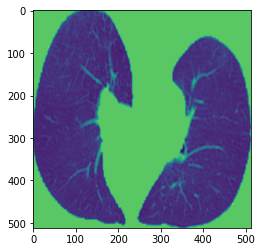

In [378]:
plt.imshow(current_slice)

In [379]:
plt.imsave('cur.jpg', current_slice)

In [380]:
t = transform(rgb_loader('cur.jpg'))

In [381]:
r = predict_semi(t)

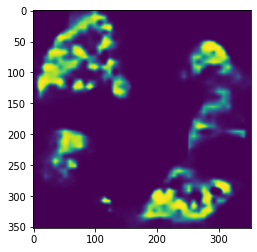

In [382]:
plt.imshow(r)
plt.imsave('semi.jpg', r)

In [383]:
e = transform(rgb_loader('semi.jpg'))

In [384]:
e.shape

torch.Size([1, 3, 352, 352])

In [385]:
def save_pseudo(path, opt = save_test):
    scan = nib.load(train_path+path)
    scan = np.array(scan.dataobj)
    for i in range(scan.shape[2]):
        p = path.replace('.nii.gz', '')+"-"+str(i)+".jpeg"
        t = get_ready(scan, slc = i)
        res = predict(t, model = semi)
        save_img(res, opt + p)

In [325]:
def store_results(path = test_path):
    for k in tqdm(os.listdir(path)):
        save_pseudo(k, opt = save_train)

In [62]:
#store_results(path = train_path)

100%|██████████| 355/355 [9:51:14<00:00, 99.93s/it]    


In [99]:
from cv2 import resize

segmentation_path = 'HACKATHON/segmentations/train/'
train_path = 'HACKATHON/images/train/'
test_path = 'HACKATHON/images/test/'
label_path = 'HACKATHON/train.txt'
saving_path = 'Results/wash/'

In [420]:
def calculate_mask_area_percentage(mask, NP_VALUE_OF_MASK):
    """
        Input je numpy array. Vrže ven odstotek, kolikšen
        del slike zajema anomalija.
    """
    mask = np.where(mask == NP_VALUE_OF_MASK, 1, 0)
    summa = np.sum(mask)
    percentage = float(summa) / (mask.shape[0]*mask.shape[1])
    return round(percentage,3)

In [421]:
def percent_lungs_slice(filepath_mask, slice_number):
    M, _ = nrrd.read(filepath_mask)
    current_slice, _ = bound_box_and_reshape(M, slice_number)
    num_pixels = current_slice.shape[2] * current_slice.shape[1]
    white = np.sum(current_slice)
    return "{:.1f}".format(white / num_pixels)

In [100]:
def save_slice(slice_image, slice_name):
    plt.imsave(os.path.join(saving_path, slice_name + ".jpg"), np.rot90(np.squeeze(slice_image), k=3),cmap='gray')

In [246]:
def bound_box_and_reshape(img, slice_idx):
    """
    Crop given slice of image to lung size (remove redundant empty space) and reshape to 512x512 pxls. Return edited img_slice.
    """
    img_slice = img[:,:,slice_idx]    
    rows = np.any(img_slice, axis=1)
    cols = np.any(img_slice, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    img_slice = resize(img_slice[rmin:rmax, cmin:cmax], (512,512))
    img_slice = np.transpose(img_slice[:, :, np.newaxis], axes = [2, 0, 1]).astype('float32')
    lung_pixels = abs((rmax-rmin) * (cmax - cmin))
    
    return img_slice, lung_pixels

# Semi Unet

In [277]:
path = 'Semi-Inf-Net_UNet/unet_model_200.pkl'

In [357]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [358]:
class Inf_Net_UNet(nn.Module):
    """ Full assembly of the parts to form the complete network """
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(Inf_Net_UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)

        return logits

In [462]:
infnet = Inf_Net_UNet(6,3)
device = torch.device('cpu')
infnet.load_state_dict(torch.load(path, map_location=device))

<All keys matched successfully>

In [360]:
#infnet.eval()

In [361]:
#plt.imsave('pseudo.jpeg', k.detach().numpy())

In [362]:
def predict_unet(k,d):
    s = torch.cat((k,d), dim=1)
    res = infnet(s)
    res = torch.sigmoid(res) 
    b, _, w, h = res.size()
    # output b*n_class*h*w -- > b*h*w
    pred = res.cpu().permute(0, 2, 3, 1).contiguous().view(-1, 3).max(1)[1].view(b, w, h).numpy().squeeze()
    return pred

In [386]:
pred = predict_unet(t,e)
ggo, conso = split_class_imgs(pred)

In [390]:
def split_class_imgs(pred):
    im_array_red = np.array(pred)  # 0, 38
    im_array_green = np.array(pred)  # 0, 75
    print(np.unique(im_array_red)) # mask value is max of this

    im_array_red[im_array_red != 0] = 1
    im_array_red[im_array_red == 0] = 255
    im_array_red[im_array_red == 1] = 0

    im_array_green[im_array_green != 1] = 0
    im_array_green[im_array_green == 1] = 255
    
   # red = Image.fromarray(im_array_red).convert('1').resize(size=(512, 512))
    #green = Image.fromarray(im_array_red).convert('1').resize(size=(512, 512))

    return im_array_green, im_array_red

In [391]:
ggo, conso = split_class_imgs(pred)

[0 1 2]


In [394]:
##  končna segmentacija(summa)

In [454]:
def process_one_patient(filename_img):
    filename_mask = filename_img.replace(".nii.gz", ".nrrd")
    filepath_img = os.path.join(train_path, filename_img)
    filepath_mask = os.path.join(segmentation_path, filename_mask)
    patient_number = filename_mask.split(".nrrd")[0]
    img = mask_original(filepath_img, filepath_mask)
    num_slices = img.shape[2]
    
    label = get_label(patient_number)
    
    patient_lung_volume_score = 0.0
    patient_ggo_score = 0.0
    patient_consolidation_score = 0.0
        
    for i in tqdm(range(num_slices)):
        try:
            current_slice, bbox_pixels = bound_box_and_reshape(img, i)
        except:
            continue
    
        current_slice = np.rot90(np.squeeze(current_slice))
        percentage = percent_lungs_slice(filepath_mask, i)
        if percentage != 0:
            plt.imsave('cur.jpg', current_slice)
            t = transform(rgb_loader('cur.jpg'))
            r = predict_semi(t)
            plt.imsave('semi.jpg', r)
            e = transform(rgb_loader('semi.jpg'))
            pred = predict_unet(t,e)
            ggo_mask, consolidation_mask = split_class_imgs(pred)
            
            NP_VALUE_OF_MASK = 255
            patient_lung_volume_score += float(percentage) * bbox_pixels
            
            ggo_percentage = calculate_mask_area_percentage(ggo_mask, NP_VALUE_OF_MASK)
            consolidation_percentage = calculate_mask_area_percentage(consolidation_mask, NP_VALUE_OF_MASK)
            
            patient_ggo_score += ggo_percentage * bbox_pixels
            patient_consolidation_score += consolidation_percentage * bbox_pixels
    
    return {"filename_img" : filename_img,
            "label" : label,
            "lung_vol": patient_lung_volume_score, 
            "ggo_vol" : patient_ggo_score, 
            "cons_vol" : patient_consolidation_score}

In [463]:
infnet.eval()
semi.eval()

Inf_Net(
  (resnet): Res2Net(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottle2neck(
        (conv1): Conv2d(64, 104, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(104, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [464]:
f = os.listdir(train_path)[:30]
training_csv = 'proba.csv'

In [465]:
def process_all_patients(path = train_path):
    training_set = []
    for _,_,filenames in os.walk(path):
        for filename in tqdm(filenames):
            if filename.endswith(".nii.gz"):
                patient_dict = process_one_patient(filename)
                with open(training_csv, mode='a') as file_:
                    file_.write(str(patient_dict.values()))
                    file_.write("\n")
                training_set.append(patient_dict)
    return training_set

In [ ]:
training_set = []
for k in f:
    patient_dict = process_one_patient(k)
    with open(training_csv, mode='a') as file_:
        file_.write(str(patient_dict.values()))
        file_.write("\n")
    training_set.append(patient_dict)

 10%|▉         | 6/62 [00:01<00:14,  3.91it/s]

[0 1 2]


 11%|█▏        | 7/62 [00:03<00:27,  1.99it/s]

[0 2]


 13%|█▎        | 8/62 [00:04<00:41,  1.29it/s]

[0 2]


 15%|█▍        | 9/62 [00:06<00:58,  1.10s/it]

[0 2]


 16%|█▌        | 10/62 [00:08<01:02,  1.21s/it]

[0 1 2]


 18%|█▊        | 11/62 [00:09<01:04,  1.26s/it]

[0 2]


 19%|█▉        | 12/62 [00:11<01:06,  1.32s/it]

[0 2]


 21%|██        | 13/62 [00:12<01:06,  1.36s/it]

[0 2]


 23%|██▎       | 14/62 [00:14<01:05,  1.36s/it]

[0 2]


 24%|██▍       | 15/62 [00:15<01:06,  1.42s/it]

[0 1 2]


 26%|██▌       | 16/62 [00:17<01:12,  1.58s/it]

[0 2]


 27%|██▋       | 17/62 [00:22<01:59,  2.65s/it]

[0 2]


 29%|██▉       | 18/62 [00:28<02:27,  3.36s/it]

[0 2]


 31%|███       | 19/62 [00:31<02:20,  3.26s/it]

[0 2]


 32%|███▏      | 20/62 [00:33<02:01,  2.89s/it]

[0 2]


 34%|███▍      | 21/62 [00:34<01:41,  2.46s/it]

[0 2]


 35%|███▌      | 22/62 [00:36<01:30,  2.27s/it]

[0 2]


 37%|███▋      | 23/62 [00:38<01:22,  2.10s/it]

[0 1 2]


 39%|███▊      | 24/62 [00:39<01:16,  2.02s/it]

[0 2]


 40%|████      | 25/62 [00:41<01:08,  1.85s/it]

[0 1 2]


 42%|████▏     | 26/62 [00:42<01:01,  1.72s/it]

[0 2]


 44%|████▎     | 27/62 [00:44<00:56,  1.62s/it]

[0 2]


 45%|████▌     | 28/62 [00:45<00:53,  1.56s/it]

[0 2]


 47%|████▋     | 29/62 [00:47<00:52,  1.60s/it]

[0 2]


 48%|████▊     | 30/62 [00:48<00:50,  1.59s/it]

[0 2]


 50%|█████     | 31/62 [00:50<00:51,  1.66s/it]

[0 2]


 52%|█████▏    | 32/62 [00:52<00:54,  1.81s/it]

[0 2]


 53%|█████▎    | 33/62 [00:54<00:51,  1.76s/it]

[0 2]


 55%|█████▍    | 34/62 [00:55<00:46,  1.67s/it]

[0 2]


 56%|█████▋    | 35/62 [00:57<00:44,  1.66s/it]

[0 2]


 58%|█████▊    | 36/62 [00:58<00:41,  1.59s/it]

[0 2]


 60%|█████▉    | 37/62 [01:00<00:38,  1.55s/it]

[0 1 2]


 61%|██████▏   | 38/62 [01:01<00:36,  1.51s/it]

[0 2]


 63%|██████▎   | 39/62 [01:03<00:34,  1.48s/it]

[0 1 2]


 65%|██████▍   | 40/62 [01:04<00:32,  1.46s/it]

[0 2]


 66%|██████▌   | 41/62 [01:06<00:30,  1.46s/it]

[0 1 2]


 68%|██████▊   | 42/62 [01:07<00:29,  1.48s/it]

[0 2]


 69%|██████▉   | 43/62 [01:09<00:28,  1.52s/it]

[0 2]


 71%|███████   | 44/62 [01:10<00:26,  1.49s/it]

[0 2]


 73%|███████▎  | 45/62 [01:12<00:24,  1.46s/it]

[0 2]


 74%|███████▍  | 46/62 [01:13<00:23,  1.48s/it]

[0 1 2]


 76%|███████▌  | 47/62 [01:15<00:22,  1.50s/it]

[0 2]


 77%|███████▋  | 48/62 [01:16<00:20,  1.48s/it]

[0 2]


 79%|███████▉  | 49/62 [01:18<00:20,  1.55s/it]

[0 2]


 81%|████████  | 50/62 [01:19<00:18,  1.51s/it]

[0 2]


 82%|████████▏ | 51/62 [01:21<00:16,  1.49s/it]

[0 1 2]


 84%|████████▍ | 52/62 [01:23<00:17,  1.70s/it]

[0 1 2]


 85%|████████▌ | 53/62 [01:25<00:16,  1.85s/it]

[0 1 2]


 87%|████████▋ | 54/62 [01:27<00:14,  1.79s/it]

[0 1 2]


 89%|████████▊ | 55/62 [01:28<00:12,  1.76s/it]

[0 1 2]


 90%|█████████ | 56/62 [01:32<00:13,  2.18s/it]

[0 1 2]


100%|██████████| 62/62 [01:34<00:00,  1.52s/it]

[0 2]



 19%|█▉        | 14/73 [00:02<00:11,  5.28it/s]

[0 1 2]


 21%|██        | 15/73 [00:05<00:23,  2.42it/s]

[0 1 2]


 22%|██▏       | 16/73 [00:06<00:30,  1.86it/s]

[0 1 2]


 23%|██▎       | 17/73 [00:08<00:38,  1.47it/s]

[0 2]


 25%|██▍       | 18/73 [00:09<00:46,  1.19it/s]

[0 2]


 26%|██▌       | 19/73 [00:11<00:55,  1.03s/it]

[0 2]


 27%|██▋       | 20/73 [00:14<01:12,  1.38s/it]

[0 2]


 29%|██▉       | 21/73 [00:15<01:12,  1.40s/it]

[0 1 2]


 30%|███       | 22/73 [00:17<01:13,  1.45s/it]

[0 1 2]


 32%|███▏      | 23/73 [00:19<01:16,  1.53s/it]

[0 1 2]


 33%|███▎      | 24/73 [00:20<01:15,  1.54s/it]

[0 1 2]


 34%|███▍      | 25/73 [00:22<01:12,  1.52s/it]

[0 1 2]


 36%|███▌      | 26/73 [00:23<01:11,  1.52s/it]

[0 2]


 37%|███▋      | 27/73 [00:25<01:11,  1.55s/it]

[0 1 2]


 38%|███▊      | 28/73 [00:26<01:08,  1.51s/it]

[0 2]


 40%|███▉      | 29/73 [00:28<01:05,  1.48s/it]

[0 2]


 41%|████      | 30/73 [00:29<01:03,  1.47s/it]

[0 2]


 42%|████▏     | 31/73 [00:31<01:01,  1.46s/it]

[0 1 2]


 44%|████▍     | 32/73 [00:32<00:59,  1.45s/it]

[0 2]


 45%|████▌     | 33/73 [00:34<01:00,  1.52s/it]

[0 2]


 47%|████▋     | 34/73 [00:35<01:00,  1.56s/it]

[0 2]


 48%|████▊     | 35/73 [00:37<00:58,  1.53s/it]

[0 2]


 49%|████▉     | 36/73 [00:38<00:55,  1.51s/it]

[0 1 2]


 51%|█████     | 37/73 [00:40<00:54,  1.50s/it]

[0 1 2]


 52%|█████▏    | 38/73 [00:41<00:53,  1.54s/it]

[0 1 2]


 53%|█████▎    | 39/73 [00:43<00:52,  1.55s/it]

[0 2]


 55%|█████▍    | 40/73 [00:45<00:57,  1.73s/it]

[0 1 2]


 56%|█████▌    | 41/73 [00:47<00:55,  1.74s/it]

[0 2]


 58%|█████▊    | 42/73 [00:49<00:53,  1.73s/it]

[0 2]


 59%|█████▉    | 43/73 [00:50<00:52,  1.76s/it]

[0 2]


 60%|██████    | 44/73 [00:52<00:49,  1.70s/it]

[0 2]


 62%|██████▏   | 45/73 [00:54<00:47,  1.69s/it]

[0 2]


 63%|██████▎   | 46/73 [00:55<00:46,  1.73s/it]

[0 2]


 64%|██████▍   | 47/73 [00:57<00:44,  1.70s/it]

[0 1 2]


 66%|██████▌   | 48/73 [00:59<00:42,  1.71s/it]

[0 2]


 67%|██████▋   | 49/73 [01:01<00:41,  1.73s/it]

[0 2]


 68%|██████▊   | 50/73 [01:02<00:39,  1.71s/it]

[0 2]


 70%|██████▉   | 51/73 [01:04<00:37,  1.69s/it]

[0 2]


 71%|███████   | 52/73 [01:06<00:36,  1.74s/it]

[0 2]


 73%|███████▎  | 53/73 [01:07<00:34,  1.70s/it]

[0 2]


 74%|███████▍  | 54/73 [01:09<00:32,  1.70s/it]

[0 2]


 75%|███████▌  | 55/73 [01:11<00:30,  1.67s/it]

[0 2]


 77%|███████▋  | 56/73 [01:12<00:28,  1.65s/it]

[0 2]


 78%|███████▊  | 57/73 [01:14<00:26,  1.66s/it]

[0 1 2]


 79%|███████▉  | 58/73 [01:15<00:24,  1.63s/it]

[0 2]


 81%|████████  | 59/73 [01:17<00:24,  1.72s/it]

[0 1 2]


 82%|████████▏ | 60/73 [01:19<00:22,  1.70s/it]

[0 1 2]


 84%|████████▎ | 61/73 [01:21<00:19,  1.65s/it]

[0 1 2]


 85%|████████▍ | 62/73 [01:22<00:17,  1.63s/it]

[0 1 2]


 86%|████████▋ | 63/73 [01:24<00:16,  1.63s/it]

[0 1 2]


100%|██████████| 73/73 [01:26<00:00,  1.18s/it]

[0 2]



  4%|▍         | 13/296 [00:01<00:38,  7.33it/s]

[0 2]


  5%|▍         | 14/296 [00:03<01:22,  3.42it/s]

[0 2]


  5%|▌         | 15/296 [00:05<02:12,  2.12it/s]

[0 1 2]


  5%|▌         | 16/296 [00:06<03:04,  1.52it/s]

[0 2]


  6%|▌         | 17/296 [00:08<04:00,  1.16it/s]

[0 2]


  6%|▌         | 18/296 [00:10<05:02,  1.09s/it]

[0 2]


  6%|▋         | 19/296 [00:12<05:45,  1.25s/it]

[0 2]


  7%|▋         | 20/296 [00:14<06:14,  1.36s/it]

[0 2]


  7%|▋         | 21/296 [00:15<06:39,  1.45s/it]

[0 1 2]


  7%|▋         | 22/296 [00:17<07:05,  1.55s/it]

[0 1 2]


  8%|▊         | 23/296 [00:19<07:20,  1.61s/it]

[0 1 2]


  8%|▊         | 24/296 [00:21<07:54,  1.74s/it]

[0 2]


  8%|▊         | 25/296 [00:23<07:52,  1.74s/it]

[0 1 2]


  9%|▉         | 26/296 [00:25<08:52,  1.97s/it]

[0 2]


  9%|▉         | 27/296 [00:27<08:40,  1.93s/it]

[0 2]


  9%|▉         | 28/296 [00:29<08:29,  1.90s/it]

[0 2]


 10%|▉         | 29/296 [00:31<08:36,  1.93s/it]

[0 2]


 10%|█         | 30/296 [00:33<08:18,  1.87s/it]

[0 2]


 10%|█         | 31/296 [00:35<08:13,  1.86s/it]

[0 2]


 11%|█         | 32/296 [00:36<08:03,  1.83s/it]

[0 2]


 11%|█         | 33/296 [00:38<08:00,  1.83s/it]

[0 2]


 11%|█▏        | 34/296 [00:40<07:49,  1.79s/it]

[0 1 2]


 12%|█▏        | 35/296 [00:42<07:48,  1.79s/it]

[0 1 2]


 12%|█▏        | 36/296 [00:43<07:40,  1.77s/it]

[0 2]


 12%|█▎        | 37/296 [00:45<07:42,  1.78s/it]

[0 2]


 13%|█▎        | 38/296 [00:47<07:44,  1.80s/it]

[0 2]


 13%|█▎        | 39/296 [00:49<07:38,  1.78s/it]

[0 2]


 14%|█▎        | 40/296 [00:51<07:57,  1.86s/it]

[0 1 2]


 14%|█▍        | 41/296 [00:53<07:46,  1.83s/it]

[0 2]


 14%|█▍        | 42/296 [00:54<07:39,  1.81s/it]

[2]


 15%|█▍        | 43/296 [00:56<07:48,  1.85s/it]

[0 2]


 15%|█▍        | 44/296 [00:58<07:46,  1.85s/it]

[0 2]


 15%|█▌        | 45/296 [01:00<07:37,  1.82s/it]

[0 2]


 16%|█▌        | 46/296 [01:02<07:42,  1.85s/it]

[0 2]


 16%|█▌        | 47/296 [01:04<07:31,  1.81s/it]

[0 2]


 16%|█▌        | 48/296 [01:05<07:20,  1.78s/it]

[0 2]


 17%|█▋        | 49/296 [01:07<07:16,  1.77s/it]

[2]


 17%|█▋        | 50/296 [01:09<07:11,  1.75s/it]

[0 2]


 17%|█▋        | 51/296 [01:11<07:08,  1.75s/it]

[0 2]


 18%|█▊        | 52/296 [01:12<07:14,  1.78s/it]

[0 2]


 18%|█▊        | 53/296 [01:14<07:15,  1.79s/it]

[0 2]


 18%|█▊        | 54/296 [01:16<07:15,  1.80s/it]

[0 2]


 19%|█▊        | 55/296 [01:18<07:09,  1.78s/it]

[0 2]


 19%|█▉        | 56/296 [01:20<07:08,  1.79s/it]

[0 2]


 19%|█▉        | 57/296 [01:21<07:14,  1.82s/it]

[0 2]


 20%|█▉        | 58/296 [01:23<07:08,  1.80s/it]

[0 2]


 20%|█▉        | 59/296 [01:25<07:03,  1.79s/it]

[0 2]


 20%|██        | 60/296 [01:27<07:00,  1.78s/it]

[0 2]


 21%|██        | 61/296 [01:29<06:59,  1.79s/it]

[0 2]


 21%|██        | 62/296 [01:30<06:58,  1.79s/it]

[0 2]


 21%|██▏       | 63/296 [01:32<07:00,  1.81s/it]

[0 2]


 22%|██▏       | 64/296 [01:34<06:50,  1.77s/it]

[0 2]


 22%|██▏       | 65/296 [01:36<06:54,  1.80s/it]

[0 2]


 22%|██▏       | 66/296 [01:37<06:50,  1.78s/it]

[0 2]


 23%|██▎       | 67/296 [01:39<06:51,  1.80s/it]

[0 2]


 23%|██▎       | 68/296 [01:41<06:48,  1.79s/it]

[0 2]


 23%|██▎       | 69/296 [01:43<06:58,  1.84s/it]

[0 2]


 24%|██▎       | 70/296 [01:45<06:52,  1.83s/it]

[0 2]


 24%|██▍       | 71/296 [01:47<06:53,  1.84s/it]

[0 2]


 24%|██▍       | 72/296 [01:48<06:45,  1.81s/it]

[0 2]


 25%|██▍       | 73/296 [01:50<06:57,  1.87s/it]

[0 2]


 25%|██▌       | 74/296 [01:52<06:44,  1.82s/it]

[0 2]


 25%|██▌       | 75/296 [01:54<06:56,  1.88s/it]

[0 2]


 26%|██▌       | 76/296 [01:56<06:47,  1.85s/it]

[0 2]


 26%|██▌       | 77/296 [01:58<06:40,  1.83s/it]

[0 1 2]


 26%|██▋       | 78/296 [01:59<06:35,  1.81s/it]

[0 2]


 27%|██▋       | 79/296 [02:01<06:25,  1.78s/it]

[0 2]


 27%|██▋       | 80/296 [02:03<06:31,  1.81s/it]

[0 2]


 27%|██▋       | 81/296 [02:05<06:30,  1.82s/it]

[0 2]


 28%|██▊       | 82/296 [02:07<06:27,  1.81s/it]

[0 1 2]


 28%|██▊       | 83/296 [02:08<06:23,  1.80s/it]

[0 2]


 28%|██▊       | 84/296 [02:10<06:19,  1.79s/it]

[0 2]


 29%|██▊       | 85/296 [02:12<06:19,  1.80s/it]

[0 1 2]


 29%|██▉       | 86/296 [02:14<06:36,  1.89s/it]

[0 2]


 29%|██▉       | 87/296 [02:16<06:27,  1.85s/it]

[0 2]


 30%|██▉       | 88/296 [02:18<06:23,  1.84s/it]

[0 1 2]


 30%|███       | 89/296 [02:20<06:16,  1.82s/it]

[0 1 2]


 30%|███       | 90/296 [02:21<06:13,  1.81s/it]

[0 2]


 31%|███       | 91/296 [02:23<06:10,  1.81s/it]

[0 1 2]


 31%|███       | 92/296 [02:25<06:15,  1.84s/it]

[0 2]


 31%|███▏      | 93/296 [02:27<06:10,  1.83s/it]

[0 2]


 32%|███▏      | 94/296 [02:29<06:03,  1.80s/it]

[0 2]


 32%|███▏      | 95/296 [02:30<06:02,  1.80s/it]

[0 2]


 32%|███▏      | 96/296 [02:32<05:58,  1.79s/it]

[0 1 2]


 33%|███▎      | 97/296 [02:34<05:56,  1.79s/it]

[0 2]


 33%|███▎      | 98/296 [02:36<05:52,  1.78s/it]

[0 2]


 33%|███▎      | 99/296 [02:38<06:03,  1.84s/it]

[0 2]


 34%|███▍      | 100/296 [02:39<05:55,  1.82s/it]

[0 2]


 34%|███▍      | 101/296 [02:41<05:49,  1.79s/it]

[0 2]


 34%|███▍      | 102/296 [02:43<05:52,  1.82s/it]

[0 1 2]


 35%|███▍      | 103/296 [02:45<05:57,  1.85s/it]

[0 1 2]


 35%|███▌      | 104/296 [02:47<05:52,  1.84s/it]

[0 1 2]


 35%|███▌      | 105/296 [02:49<05:47,  1.82s/it]

[0 1 2]


 36%|███▌      | 106/296 [02:50<05:48,  1.83s/it]

[0 2]


 36%|███▌      | 107/296 [02:52<05:45,  1.83s/it]

[0 1 2]


 36%|███▋      | 108/296 [02:54<05:37,  1.79s/it]

[0 1 2]


 37%|███▋      | 109/296 [02:56<05:45,  1.85s/it]

[0 1 2]


 37%|███▋      | 110/296 [02:58<05:41,  1.84s/it]

[0 1 2]


 38%|███▊      | 111/296 [03:00<05:38,  1.83s/it]

[0 2]


 38%|███▊      | 112/296 [03:01<05:32,  1.81s/it]

[0 1 2]


 38%|███▊      | 113/296 [03:03<05:31,  1.81s/it]

[0 1 2]


 39%|███▊      | 114/296 [03:05<05:26,  1.80s/it]

[0 1 2]


 39%|███▉      | 115/296 [03:07<05:24,  1.79s/it]

[0 1 2]


 39%|███▉      | 116/296 [03:09<05:26,  1.82s/it]

[0 2]


 40%|███▉      | 117/296 [03:10<05:22,  1.80s/it]

[0 2]


 40%|███▉      | 118/296 [03:12<05:17,  1.79s/it]

[0 1 2]


 40%|████      | 119/296 [03:14<05:22,  1.82s/it]

[0 2]


 41%|████      | 120/296 [03:16<05:29,  1.87s/it]

[0 1 2]


 41%|████      | 121/296 [03:18<05:26,  1.86s/it]

[0 1 2]


 41%|████      | 122/296 [03:20<05:28,  1.89s/it]

[0 1 2]


 42%|████▏     | 123/296 [03:22<05:23,  1.87s/it]

[0 1 2]


 42%|████▏     | 124/296 [03:23<05:19,  1.86s/it]

[0 1 2]


 42%|████▏     | 125/296 [03:25<05:11,  1.82s/it]

[0 1 2]


 43%|████▎     | 126/296 [03:27<05:21,  1.89s/it]

[0 2]


 43%|████▎     | 127/296 [03:29<05:14,  1.86s/it]

[0 1 2]


 43%|████▎     | 128/296 [03:31<05:10,  1.85s/it]

[0 1 2]


 44%|████▎     | 129/296 [03:33<05:04,  1.83s/it]

[0 1 2]


 44%|████▍     | 130/296 [03:34<05:01,  1.81s/it]

[0 1 2]


 44%|████▍     | 131/296 [03:36<05:03,  1.84s/it]

[0 1 2]


 45%|████▍     | 132/296 [03:38<04:59,  1.83s/it]

[0 1 2]


 45%|████▍     | 133/296 [03:40<04:56,  1.82s/it]

[0 1 2]


 45%|████▌     | 134/296 [03:42<04:57,  1.83s/it]

[0 1 2]


 46%|████▌     | 135/296 [03:43<04:51,  1.81s/it]

[0 1 2]


 46%|████▌     | 136/296 [03:45<04:48,  1.81s/it]

[0 1 2]


 46%|████▋     | 137/296 [03:47<04:59,  1.88s/it]

[0 1 2]


 47%|████▋     | 138/296 [03:49<05:02,  1.92s/it]

[0 1 2]


 47%|████▋     | 139/296 [03:51<05:12,  1.99s/it]

[0 2]


 47%|████▋     | 140/296 [03:53<05:05,  1.96s/it]

[0 1 2]


 48%|████▊     | 141/296 [03:55<05:03,  1.96s/it]

[0 2]


 48%|████▊     | 142/296 [03:57<05:06,  1.99s/it]

[0 1 2]


 48%|████▊     | 143/296 [04:00<05:30,  2.16s/it]

[0 1 2]


 49%|████▊     | 144/296 [04:02<05:23,  2.13s/it]

[0 1 2]


 49%|████▉     | 145/296 [04:04<05:12,  2.07s/it]

[0 1 2]


 49%|████▉     | 146/296 [04:06<05:07,  2.05s/it]

[0 1 2]


 50%|████▉     | 147/296 [04:08<05:17,  2.13s/it]

[0 2]


 50%|█████     | 148/296 [04:10<05:05,  2.07s/it]

[0 2]


 50%|█████     | 149/296 [04:12<05:00,  2.05s/it]

[0 2]


 51%|█████     | 150/296 [04:14<04:56,  2.03s/it]

[0 1 2]


 51%|█████     | 151/296 [04:16<04:53,  2.03s/it]

[0 1 2]


 51%|█████▏    | 152/296 [04:18<04:56,  2.06s/it]

[0 2]


 52%|█████▏    | 153/296 [04:20<04:50,  2.03s/it]

[0 1 2]


 52%|█████▏    | 154/296 [04:22<04:54,  2.07s/it]

[0 1 2]


 52%|█████▏    | 155/296 [04:24<04:50,  2.06s/it]

[0 1 2]


 53%|█████▎    | 156/296 [04:27<04:48,  2.06s/it]

[0 1 2]


 53%|█████▎    | 157/296 [04:29<04:57,  2.14s/it]

[0 1 2]


 53%|█████▎    | 158/296 [04:31<04:55,  2.14s/it]

[0 2]


 54%|█████▎    | 159/296 [04:33<04:48,  2.11s/it]

[0 1 2]


 54%|█████▍    | 160/296 [04:35<04:42,  2.08s/it]

[0 1 2]


 54%|█████▍    | 161/296 [04:37<04:43,  2.10s/it]

[0 1 2]


 55%|█████▍    | 162/296 [04:40<04:53,  2.19s/it]

[0 1 2]


 55%|█████▌    | 163/296 [04:42<04:42,  2.12s/it]

[0 1 2]


 55%|█████▌    | 164/296 [04:44<04:33,  2.07s/it]

[0 1 2]


 56%|█████▌    | 165/296 [04:45<04:24,  2.02s/it]

[0 1 2]


 56%|█████▌    | 166/296 [04:47<04:22,  2.02s/it]

[0 2]


 56%|█████▋    | 167/296 [04:50<04:25,  2.06s/it]

[0 1 2]


 57%|█████▋    | 168/296 [04:52<04:24,  2.06s/it]

[0 2]


 57%|█████▋    | 169/296 [04:54<04:19,  2.04s/it]

[0 1 2]


 57%|█████▋    | 170/296 [04:56<04:17,  2.04s/it]

[0 1 2]


 58%|█████▊    | 171/296 [04:58<04:14,  2.04s/it]

[0 1 2]


 58%|█████▊    | 172/296 [05:00<04:22,  2.12s/it]

[0 1 2]


 58%|█████▊    | 173/296 [05:02<04:02,  1.97s/it]

[0 1 2]


 59%|█████▉    | 174/296 [05:03<03:49,  1.88s/it]

[0 1 2]


 59%|█████▉    | 175/296 [05:05<03:37,  1.80s/it]

[0 1 2]


 59%|█████▉    | 176/296 [05:07<03:29,  1.74s/it]

[0 2]


 60%|█████▉    | 177/296 [05:08<03:25,  1.73s/it]

[0 1 2]


 60%|██████    | 178/296 [05:10<03:28,  1.76s/it]

[0 2]


 60%|██████    | 179/296 [05:12<03:20,  1.71s/it]

[0 1 2]


 61%|██████    | 180/296 [05:13<03:13,  1.67s/it]

[0 1 2]


 61%|██████    | 181/296 [05:15<03:09,  1.65s/it]

[0 1 2]


 61%|██████▏   | 182/296 [05:16<03:05,  1.63s/it]

[0 2]


 62%|██████▏   | 183/296 [05:18<03:01,  1.61s/it]

[0 1 2]


 62%|██████▏   | 184/296 [05:20<02:58,  1.59s/it]

[0 1 2]


 62%|██████▎   | 185/296 [05:21<03:02,  1.64s/it]

[0 1 2]


 63%|██████▎   | 186/296 [05:23<03:00,  1.64s/it]

[0 1 2]


 63%|██████▎   | 187/296 [05:25<03:18,  1.82s/it]

[0 1 2]


 64%|██████▎   | 188/296 [05:27<03:17,  1.83s/it]

[0 2]


 64%|██████▍   | 189/296 [05:29<03:09,  1.77s/it]

[0 2]


 64%|██████▍   | 190/296 [05:30<03:09,  1.79s/it]

[0 2]


 65%|██████▍   | 191/296 [05:32<03:03,  1.75s/it]

[0 2]


 65%|██████▍   | 192/296 [05:34<02:58,  1.72s/it]

[0 2]


 65%|██████▌   | 193/296 [05:36<03:12,  1.87s/it]

[0 2]


 66%|██████▌   | 194/296 [05:38<03:15,  1.91s/it]

[0 2]


 66%|██████▌   | 195/296 [05:40<03:15,  1.93s/it]

[0 2]


 66%|██████▌   | 196/296 [05:42<03:26,  2.07s/it]

[0 1 2]


 67%|██████▋   | 197/296 [05:44<03:23,  2.05s/it]

[0 1 2]


 67%|██████▋   | 198/296 [05:46<03:20,  2.04s/it]

[0 1 2]


 67%|██████▋   | 199/296 [05:49<03:23,  2.10s/it]

[0 2]


 68%|██████▊   | 200/296 [05:50<03:14,  2.02s/it]

[0 1 2]


 68%|██████▊   | 201/296 [05:52<03:10,  2.00s/it]

[0 1 2]


 68%|██████▊   | 202/296 [05:54<03:02,  1.94s/it]

[0 2]


 69%|██████▊   | 203/296 [05:56<02:59,  1.93s/it]

[0 2]


 69%|██████▉   | 204/296 [05:58<02:57,  1.93s/it]

[0 2]


 69%|██████▉   | 205/296 [06:00<02:53,  1.91s/it]

[0 2]


 70%|██████▉   | 206/296 [06:02<02:57,  1.97s/it]

[0 2]


 70%|██████▉   | 207/296 [06:04<02:50,  1.92s/it]

[0 2]


 70%|███████   | 208/296 [06:06<02:47,  1.91s/it]

[0 2]


 71%|███████   | 209/296 [06:08<02:46,  1.91s/it]

[0 2]


 71%|███████   | 210/296 [06:10<02:44,  1.92s/it]

[0 2]


 71%|███████▏  | 211/296 [06:11<02:42,  1.91s/it]

[0 1 2]


 72%|███████▏  | 212/296 [06:14<02:43,  1.95s/it]

[0 2]


 72%|███████▏  | 213/296 [06:15<02:38,  1.91s/it]

[0 2]


 72%|███████▏  | 214/296 [06:17<02:39,  1.95s/it]

[0 2]


 73%|███████▎  | 215/296 [06:19<02:37,  1.94s/it]

[0 2]


 73%|███████▎  | 216/296 [06:21<02:39,  1.99s/it]

[0 2]


 73%|███████▎  | 217/296 [06:24<02:46,  2.10s/it]

[0 1 2]


 74%|███████▎  | 218/296 [06:26<02:41,  2.07s/it]

[0 1 2]


 74%|███████▍  | 219/296 [06:28<02:34,  2.00s/it]

[0 1 2]


 74%|███████▍  | 220/296 [06:30<02:32,  2.00s/it]

[0 1 2]


 75%|███████▍  | 221/296 [06:32<02:29,  1.99s/it]

[0 2]


 75%|███████▌  | 222/296 [06:34<02:30,  2.03s/it]

[0 1 2]


 75%|███████▌  | 223/296 [06:36<02:26,  2.00s/it]

[0 1 2]


 76%|███████▌  | 224/296 [06:38<02:21,  1.97s/it]

[0 2]


 76%|███████▌  | 225/296 [06:39<02:18,  1.95s/it]

[0 2]


 76%|███████▋  | 226/296 [06:41<02:14,  1.91s/it]

[0 1 2]


 77%|███████▋  | 227/296 [06:43<02:13,  1.94s/it]

[0 2]


 77%|███████▋  | 228/296 [06:45<02:09,  1.90s/it]

[0 1 2]


 77%|███████▋  | 229/296 [06:47<02:06,  1.89s/it]

[0 1 2]


 78%|███████▊  | 230/296 [06:49<02:05,  1.91s/it]

[0 1 2]


 78%|███████▊  | 231/296 [06:51<02:02,  1.88s/it]

[0 1 2]


 78%|███████▊  | 232/296 [06:53<02:00,  1.88s/it]

[0 2]


 79%|███████▊  | 233/296 [06:55<01:59,  1.90s/it]

[0 1 2]


 79%|███████▉  | 234/296 [06:56<01:57,  1.90s/it]

[0 2]


 79%|███████▉  | 235/296 [06:58<01:53,  1.87s/it]

[0 1 2]


 80%|███████▉  | 236/296 [07:00<01:51,  1.86s/it]

[0 1 2]


 80%|████████  | 237/296 [07:02<01:49,  1.85s/it]

[0 1 2]


 80%|████████  | 238/296 [07:04<01:54,  1.97s/it]

[0 1 2]


 81%|████████  | 239/296 [07:06<01:48,  1.91s/it]

[0 1 2]


 81%|████████  | 240/296 [07:08<01:42,  1.84s/it]

[0 2]


 81%|████████▏ | 241/296 [07:09<01:38,  1.78s/it]

[0 2]


 82%|████████▏ | 242/296 [07:11<01:33,  1.73s/it]

[0 1 2]


 82%|████████▏ | 243/296 [07:12<01:30,  1.70s/it]

[0 1 2]


 82%|████████▏ | 244/296 [07:14<01:29,  1.72s/it]

[0 2]


 83%|████████▎ | 245/296 [07:16<01:26,  1.69s/it]

[0 2]


 83%|████████▎ | 246/296 [07:17<01:23,  1.67s/it]

[0 1 2]


 83%|████████▎ | 247/296 [07:19<01:20,  1.64s/it]

[0 1 2]


 84%|████████▍ | 248/296 [07:21<01:17,  1.62s/it]

[0 2]


 84%|████████▍ | 249/296 [07:22<01:16,  1.63s/it]

[0 1 2]


 84%|████████▍ | 250/296 [07:24<01:14,  1.61s/it]

[0 2]


 85%|████████▍ | 251/296 [07:27<01:30,  2.00s/it]

[0 1 2]


 85%|████████▌ | 252/296 [07:28<01:24,  1.92s/it]

[0 1 2]


 85%|████████▌ | 253/296 [07:30<01:19,  1.84s/it]

[0 1 2]


 86%|████████▌ | 254/296 [07:32<01:16,  1.82s/it]

[0 1 2]


 86%|████████▌ | 255/296 [07:34<01:12,  1.77s/it]

[0 1 2]


 86%|████████▋ | 256/296 [07:35<01:11,  1.79s/it]

[0 1 2]


 87%|████████▋ | 257/296 [07:37<01:08,  1.76s/it]

[0 2]


 87%|████████▋ | 258/296 [07:40<01:16,  2.02s/it]

[0 1 2]


 88%|████████▊ | 259/296 [07:42<01:14,  2.01s/it]

[0 1 2]


 88%|████████▊ | 260/296 [07:43<01:09,  1.93s/it]

[0 1 2]


 88%|████████▊ | 261/296 [07:45<01:08,  1.95s/it]

[0 2]


 89%|████████▊ | 262/296 [07:47<01:03,  1.86s/it]

[0 2]


 89%|████████▉ | 263/296 [07:49<01:02,  1.89s/it]

[0 2]


 89%|████████▉ | 264/296 [07:51<00:58,  1.81s/it]

[0 2]


 90%|████████▉ | 265/296 [07:52<00:54,  1.76s/it]

[0 2]


 90%|████████▉ | 266/296 [07:54<00:51,  1.73s/it]

[0 1 2]


 90%|█████████ | 267/296 [07:56<00:52,  1.79s/it]

[0 1 2]


 91%|█████████ | 268/296 [07:58<00:48,  1.75s/it]

[0 1 2]


 91%|█████████ | 269/296 [07:59<00:46,  1.72s/it]

[0 1 2]


 91%|█████████ | 270/296 [08:01<00:44,  1.71s/it]

[0 1 2]


 92%|█████████▏| 271/296 [08:03<00:42,  1.70s/it]

[0 2]


100%|██████████| 296/296 [08:04<00:00,  1.64s/it]

[0 1 2]



 11%|█▏        | 35/306 [00:01<00:13, 20.31it/s]

[0 2]
[0 1 2]
[0 1 2]


 12%|█▏        | 38/306 [00:06<00:59,  4.48it/s]

[0 1 2]


 13%|█▎        | 39/306 [00:08<01:20,  3.32it/s]

[0 1 2]


 13%|█▎        | 40/306 [00:12<02:17,  1.93it/s]

[0 1 2]


 13%|█▎        | 41/306 [00:15<03:15,  1.36it/s]

[0 1 2]


 14%|█▎        | 42/306 [00:16<03:46,  1.17it/s]

[0 1 2]


 14%|█▍        | 43/306 [00:19<04:35,  1.05s/it]

[0 1 2]


 14%|█▍        | 44/306 [00:21<05:20,  1.22s/it]

[0 1 2]


 15%|█▍        | 45/306 [00:22<05:40,  1.30s/it]

[0 2]


 15%|█▌        | 46/306 [00:24<05:58,  1.38s/it]

[0 2]


 15%|█▌        | 47/306 [00:26<06:11,  1.43s/it]

[0 2]


 16%|█▌        | 48/306 [00:27<06:26,  1.50s/it]

[0 2]


 16%|█▌        | 49/306 [00:29<06:30,  1.52s/it]

[0 2]


 16%|█▋        | 50/306 [00:31<06:31,  1.53s/it]

[0 2]


 17%|█▋        | 51/306 [00:32<06:40,  1.57s/it]

[0 2]


 17%|█▋        | 52/306 [00:34<06:43,  1.59s/it]

[0 2]


 17%|█▋        | 53/306 [00:36<06:55,  1.64s/it]

[2]


 18%|█▊        | 54/306 [00:38<07:17,  1.73s/it]

[0 2]


 18%|█▊        | 55/306 [00:39<07:12,  1.72s/it]

[0 2]


 18%|█▊        | 56/306 [00:42<07:51,  1.89s/it]

[0 2]


 19%|█▊        | 57/306 [00:43<07:26,  1.79s/it]

[0 2]


 19%|█▉        | 58/306 [00:45<07:47,  1.88s/it]

[0 2]


 19%|█▉        | 59/306 [00:48<08:15,  2.01s/it]

[0 2]


 20%|█▉        | 60/306 [00:49<08:00,  1.95s/it]

[0 2]


 20%|█▉        | 61/306 [00:51<08:01,  1.96s/it]

[0 2]


 20%|██        | 62/306 [00:53<08:04,  1.99s/it]

[0 2]


 21%|██        | 63/306 [00:55<07:58,  1.97s/it]

[0 2]


 21%|██        | 64/306 [00:57<07:51,  1.95s/it]

[0 2]


 21%|██        | 65/306 [00:59<07:37,  1.90s/it]

[0 2]


 22%|██▏       | 66/306 [01:01<07:30,  1.88s/it]

[0 2]


 22%|██▏       | 67/306 [01:03<07:44,  1.94s/it]

[0 2]


 22%|██▏       | 68/306 [01:05<07:35,  1.91s/it]

[0 2]


 23%|██▎       | 69/306 [01:07<07:26,  1.88s/it]

[0 2]


 23%|██▎       | 70/306 [01:08<07:18,  1.86s/it]

[0 2]


 23%|██▎       | 71/306 [01:10<07:24,  1.89s/it]

[0 2]


 24%|██▎       | 72/306 [01:12<07:28,  1.91s/it]

[0 2]


 24%|██▍       | 73/306 [01:14<07:20,  1.89s/it]

[0 2]


 24%|██▍       | 74/306 [01:16<07:27,  1.93s/it]

[0 2]


 25%|██▍       | 75/306 [01:18<07:19,  1.90s/it]

[0 2]


 25%|██▍       | 76/306 [01:20<07:09,  1.87s/it]

[0 2]


 25%|██▌       | 77/306 [01:22<07:03,  1.85s/it]

[0 2]


 25%|██▌       | 78/306 [01:24<07:09,  1.88s/it]

[0 2]


 26%|██▌       | 79/306 [01:25<07:05,  1.88s/it]

[0 2]


 26%|██▌       | 80/306 [01:27<07:06,  1.89s/it]

[0 2]


 26%|██▋       | 81/306 [01:29<07:09,  1.91s/it]

[0 2]


 27%|██▋       | 82/306 [01:31<07:13,  1.94s/it]

[0 2]


 27%|██▋       | 83/306 [01:34<07:28,  2.01s/it]

[0 2]


 27%|██▋       | 84/306 [01:36<07:30,  2.03s/it]

[0 2]


 28%|██▊       | 85/306 [01:38<07:24,  2.01s/it]

[0 2]


 28%|██▊       | 86/306 [01:40<07:19,  2.00s/it]

[0 2]


 28%|██▊       | 87/306 [01:42<07:14,  1.99s/it]

[0 2]


 29%|██▉       | 88/306 [01:44<07:50,  2.16s/it]

[0 2]


 29%|██▉       | 89/306 [01:46<07:38,  2.11s/it]

[0 2]


 29%|██▉       | 90/306 [01:48<07:26,  2.07s/it]

[0 2]


 30%|██▉       | 91/306 [01:50<07:16,  2.03s/it]

[0 2]


 30%|███       | 92/306 [01:52<07:12,  2.02s/it]

[0 2]


 30%|███       | 93/306 [01:59<13:00,  3.67s/it]

[0 2]


 31%|███       | 94/306 [02:02<11:13,  3.18s/it]

[0 2]


 31%|███       | 95/306 [02:03<09:51,  2.81s/it]

[0 2]


 31%|███▏      | 96/306 [02:06<09:12,  2.63s/it]

[0 2]


 32%|███▏      | 97/306 [02:08<08:27,  2.43s/it]

[0 2]


 32%|███▏      | 98/306 [02:10<08:02,  2.32s/it]

[0 2]


 32%|███▏      | 99/306 [02:12<07:49,  2.27s/it]

[0 2]


 33%|███▎      | 100/306 [02:20<14:15,  4.15s/it]

[0 2]


 33%|███▎      | 101/306 [02:28<17:45,  5.20s/it]

[0 2]


 33%|███▎      | 102/306 [02:30<14:02,  4.13s/it]

[0 1 2]


 34%|███▎      | 103/306 [02:31<11:27,  3.38s/it]

[0 2]


 34%|███▍      | 104/306 [02:33<09:38,  2.86s/it]

[0 2]


 34%|███▍      | 105/306 [02:35<08:22,  2.50s/it]

[0 2]


 35%|███▍      | 106/306 [02:36<07:41,  2.31s/it]

[0 2]


 35%|███▍      | 107/306 [02:38<07:00,  2.12s/it]

[0 2]


 35%|███▌      | 108/306 [02:40<06:30,  1.97s/it]

[0 2]


 36%|███▌      | 109/306 [02:41<06:11,  1.89s/it]

[0 2]


 36%|███▌      | 110/306 [02:43<05:55,  1.82s/it]

[0 2]


 36%|███▋      | 111/306 [02:45<05:44,  1.77s/it]

[0 1 2]


 37%|███▋      | 112/306 [02:47<05:56,  1.84s/it]

[0 2]


 37%|███▋      | 113/306 [02:48<05:46,  1.79s/it]

[0 1 2]


 37%|███▋      | 114/306 [02:50<05:32,  1.73s/it]

[0 2]


 38%|███▊      | 115/306 [02:52<05:24,  1.70s/it]

[0 1 2]


 38%|███▊      | 116/306 [02:53<05:13,  1.65s/it]

[0 1 2]


 38%|███▊      | 117/306 [02:55<05:12,  1.65s/it]

[0 2]


 39%|███▊      | 118/306 [02:57<05:16,  1.68s/it]

[0 2]


 39%|███▉      | 119/306 [02:58<05:10,  1.66s/it]

[0 2]


 39%|███▉      | 120/306 [03:00<05:05,  1.64s/it]

[0 2]


 40%|███▉      | 121/306 [03:01<05:01,  1.63s/it]

[0 2]


 40%|███▉      | 122/306 [03:03<04:58,  1.62s/it]

[0 2]


 40%|████      | 123/306 [03:05<04:55,  1.61s/it]

[0 2]


 41%|████      | 124/306 [03:07<05:44,  1.89s/it]

[0 2]


 41%|████      | 125/306 [03:15<10:54,  3.62s/it]

[0 2]


 41%|████      | 126/306 [03:22<14:28,  4.82s/it]

[0 2]


 42%|████▏     | 127/306 [03:30<16:35,  5.56s/it]

[0 1 2]


 42%|████▏     | 128/306 [03:38<18:29,  6.23s/it]

[0 1 2]


In [42]:
## isto naredi tudi z slikami za unet, 

In [43]:
print("Eh")

Eh
